Model orthogonalization with LDM variants. This is an interactive jupyter notebook, that contains the following model scenarios:

* 4 classes, 2 models of each class
* 1 good model 7 bad models
* 4 good models 4 bad models
* 7 good models 1 bad model
* 1 model perfect 7 models bad

These scenarios are examined using PCA. One needs to make some choices when analyzing the scenarios, which in turn yields the following PCA variants:

* Raw model output  -  not standardized
* Raw model output  -  standardized
* Residuals - not standardized
* Residuals - standardized

Example: Let's say you are interested in the scenario with **1 model perfect 7 models bad** and you want to analyze **standardized residuals**, then you need to run the code chunks under the **following headings**:

1. Utilities
2. Scenario - 1 model perfect 7 models bad
3. Residuals - standardized

This is the code hierarchy:

    ├── Utilities
    └── Version 2.0 - LDM variants
        ├── 4 classes, 2 models of each class
        ├── 1 good model 7 bad models
        ├── 4 good models 4 bad models
        ├── 7 good models 1 bad model
        ├── 1 model perfect 7 models bad
        ├──  8 perfect models with a various scales random corruption
    └── PCA - Analysis
        ├── Raw model output  -  not standardized
        ├── Raw model output  -  standardized
        ├── Residuals - not standardized
        ├── Residuals - standardized
        
**I recommend to have Collapsible Headings nbextension active for the best experience.**

## Utilities

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#def LDM_extended(params, x):
#    #x = (n,z)
#    #params= parameters (volume, surface, curv, sym, ssym, sym_2)
#    
#    n=x[0]
#    z=x[1]
#    A = n + z
#    I = (n-z)/(n+z)
#    #I = 0
#
#    return params[0] + params[1] * A ** (-1/3) + params[2] * A ** (-2/3)  +  params[3] * I ** 2 + \
#                + params[4] * (I ** 2) * A ** (-1/3) + params[5] * (I ** 4)

def LDM_extended(params, x): 
    #x = (n,z)
    #params= parameters (volume, surface, curv, sym, ssym, sym_2, Coulomb)
    
    n=x[0]
    z=x[1]
    A = n + z
    I = (n-z)/(n+z)
    #I = 0

    return params[0] + params[1] * A ** (-1/3) + params[2] * A ** (-2/3)  +  params[3] * I ** 2 + \
                + params[4] * (I ** 2) * A ** (-1/3) + params[5] * (I ** 4) + params[6]*((z**2)/((n+z)**(4/3))) 




def Truth(x):
    return LDM(LDM_truth_params,x)

#We should create the data (paris of [N,Z])
def data_loader():
    #input_NZ = pd.read_csv("NZ.txt", delim_whitespace=True, header = None)
    input_NZ = pd.read_csv("NZ_even_even.txt", delim_whitespace=True, header = None)
    input_NZ.columns = ["N", "Z"]
    return input_NZ

def loading_matrix(loadings, n_features, feature_names):
    # Loadings

    # PC names
    pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

    # Match PC names to loadings
    pc_loadings = dict(zip(pc_list, loadings))

    # Matrix of corr coefs between feature names and PCs
    loadings_df = pd.DataFrame.from_dict(pc_loadings)
    loadings_df['feature_names'] = feature_names
    loadings_df = loadings_df.set_index('feature_names')
    return loadings_df

def biplot(score,coef,labels=None):
 
    xs = score[:,0]
    ys = score[:,1]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, s=5, color='orange')
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'darkblue', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
    return

### Global variables####

# SkO values selected for the truth
#truth_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5]
truth_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5,0.57]

# SLy4 values selected for the truth
SLY_params = [-15.972, 18.4, 9, 32.01, -54, - 4.5 * (95.97 ** 2) * (0.1596**2) / 230.1, 0.57]
# NL_1 params
NL1_params = [-16.425, 18.8, 9, 43.48, -110, -4.5 *(311.18 **2) *(0.1518**2)/211.3, 0.57]
corruption_noise_Mass=1/3

c1_params = [SLY_params, NL1_params]
c2_params = [[-15.972, 18.4, 9, 32.01, -54, 0, 0.57], [-16.425, 18.8, 9, 43.48, -110, 0, 0.57]]
c3_params = [[-15.972, 18.4, 9, 32.01, 0, 0, 0.57], [-16.425, 18.8, 9, 43.48, 0, 0, 0.57]]
c4_params = [[-15.972, 18.4, 9, 0, 0, 0, 0.57], [-16.425, 18.8, 9, 0, 0, 0, 0.57]]

##########################

## Version 2.0 - LDM variants

### Scenario - 4 classes, 2 models of each class

In [55]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
scenario = "original"

# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 2
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

# Model class 2: truth + quadratic distortion + noise
n_class_2 = 2
params = c2_params
for i in range(n_class_2):
    models_output["c2_" +  models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])
    
n_class_3 = 2
params = c3_params
for i in range(n_class_3):
    models_output["c3_" +  models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

n_class_4 = 2
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

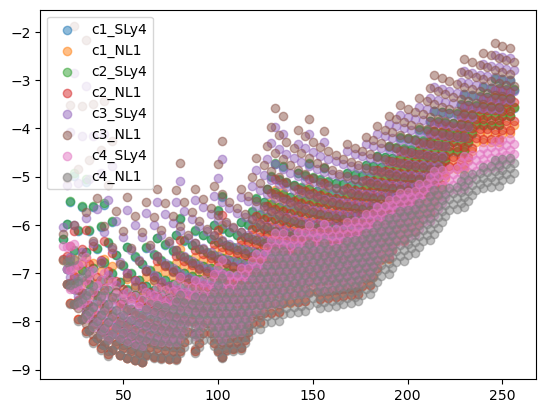

In [56]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

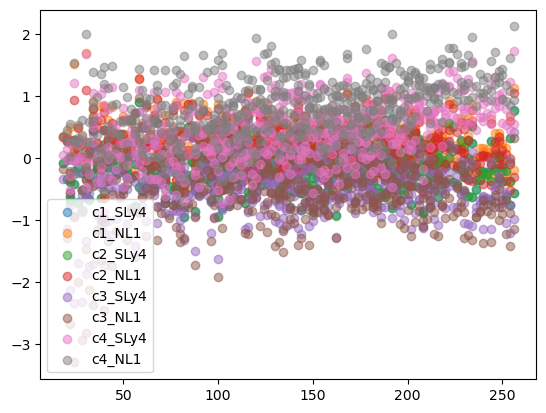

In [57]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y =masses_truth.values -  models_output_df[key].values, label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [58]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.to_latex())

             mean       std  res_mean   res_std      rmse
c1_SLy4 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_NL1  -6.558030  1.332515  0.267623  0.335448  0.429124
c2_SLy4 -6.139804  1.336492 -0.150603  0.323793  0.357104
c2_NL1  -6.504928  1.364964  0.214521  0.328425  0.392278
c3_SLy4 -5.832142  1.465550 -0.458265  0.422822  0.623527
c3_NL1  -5.878209  1.632567 -0.412198  0.569078  0.702679
c4_SLy4 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_NL1  -7.107644  1.023128  0.817237  0.475797  0.945653
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4 & -6.144931 & 1.333014 & -0.145476 & 0.323206 & 0.354437 \\
c1_NL1 & -6.558030 & 1.332515 & 0.267623 & 0.335448 & 0.429124 \\
c2_SLy4 & -6.139804 & 1.336492 & -0.150603 & 0.323793 & 0.357104 \\
c2_NL1 & -6.504928 & 1.364964 & 0.214521 & 0.328425 & 0.392278 \\
c3_SLy4 & -5.832142 & 1.465550 & -0.458265 & 0.422822 & 0.623527 \\
c3_NL1 & -5.878209 & 1.632567 & -0.412198 & 0.569078 & 0.702679 \\
c4_SLy

### Scenario - 1 good model 7 bad models

In [68]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "1g7b"
# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 1
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

n_class_4 = 7
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

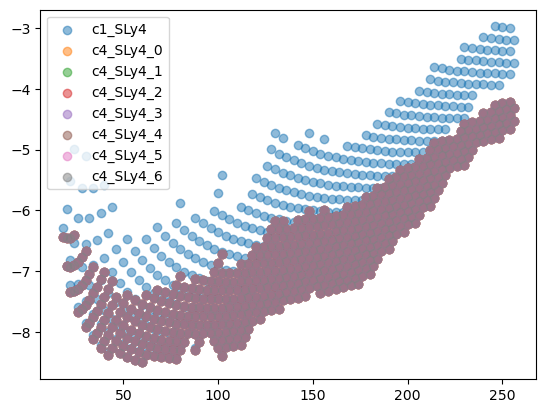

In [69]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [70]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

               mean       std  res_mean   res_std      rmse
c1_SLy4   -6.144931  1.333014 -0.145476  0.323206  0.354437
c4_SLy4_0 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_1 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_2 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_3 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_4 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_5 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_6 -6.737253  1.034223  0.446846  0.469164  0.647909
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c4_SLy4_0 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_1 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_2 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_3 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_4 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_5 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_6 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\


### Scenario - 4 good models 4 bad models

In [78]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "4g4b"
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 4
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])

n_class_4 = 4
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])
    

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

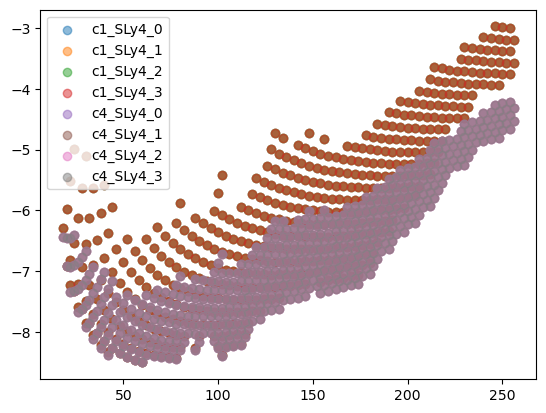

In [79]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [80]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())

               mean       std  res_mean   res_std      rmse
c1_SLy4_0 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_1 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_2 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_3 -6.144931  1.333014 -0.145476  0.323206  0.354437
c4_SLy4_0 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_1 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_2 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_3 -6.737253  1.034223  0.446846  0.469164  0.647909
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4_0 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_1 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_2 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_3 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c4_SLy4_0 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_1 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_2 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_3 & -6.74 & 1.03 & 0.45 & 0.47 & 0.6

### Scenario - 7 good models 1 bad model

In [88]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "7g1b"

# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 7
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])

n_class_4 = 1
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])
    

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

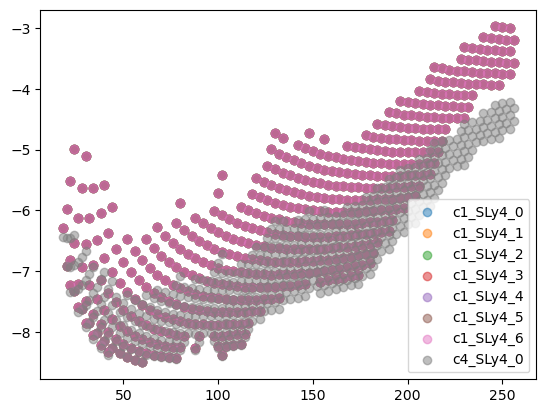

In [89]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [90]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())

               mean       std  res_mean   res_std      rmse
c1_SLy4_0 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_1 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_2 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_3 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_4 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_5 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_6 -6.144931  1.333014 -0.145476  0.323206  0.354437
c4_SLy4_0 -6.737253  1.034223  0.446846  0.469164  0.647909
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4_0 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_1 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_2 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_3 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_4 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_5 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_6 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c4_SLy4_0 & -6.74 & 1.03 & 0.45 & 0.47 & 

### Scenario - 1 model perfect 7 models bad

In [120]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "1p7b"
corruption_noise_Mass=1/3

# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 1
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[i]] = masses_truth + np.random.randn(masses_truth.shape[0]) * 0.001

n_class_4 = 7
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])
models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

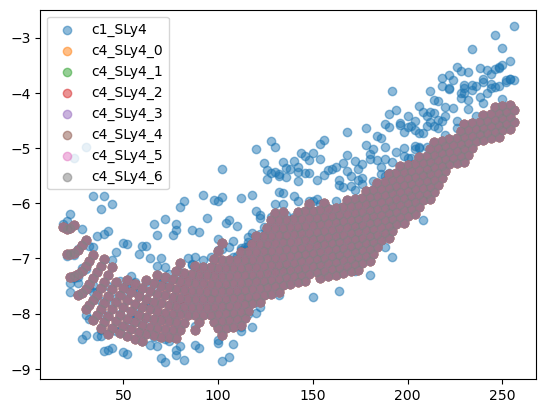

In [121]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [122]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())

               mean       std  res_mean   res_std      rmse
c1_SLy4   -6.290487  1.359034  0.000080  0.000978  0.000982
c4_SLy4_0 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_1 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_2 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_3 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_4 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_5 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_6 -6.737253  1.034223  0.446846  0.469164  0.647909
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4 & -6.29 & 1.36 & 0.00 & 0.00 & 0.00 \\
c4_SLy4_0 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_1 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_2 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_3 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_4 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_5 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_6 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
\

### Scenario - 8 perfect models with a various scales random corruption

In [156]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "8p0b"
corruption_noise_Mass=1/3

# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
noise_scale = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128]
n_class_1 = 8
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + str(i)] = masses_truth + np.random.randn(masses_truth.shape[0]) * noise_scale[i]
    
models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

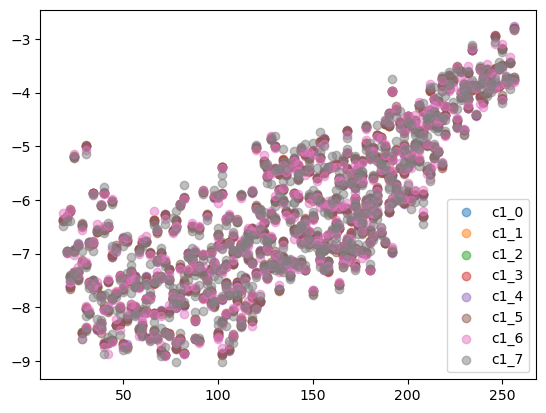

In [157]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [158]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())

          mean       std  res_mean   res_std      rmse
c1_0 -6.290487  1.359034  0.000080  0.000978  0.000982
c1_1 -6.290429  1.359250  0.000022  0.002042  0.002042
c1_2 -6.290275  1.359050 -0.000132  0.004033  0.004035
c1_3 -6.290769  1.359168  0.000362  0.008094  0.008102
c1_4 -6.291850  1.360144  0.001443  0.016639  0.016702
c1_5 -6.291154  1.361478  0.000747  0.031225  0.031234
c1_6 -6.292916  1.361066  0.002509  0.064274  0.064323
c1_7 -6.290591  1.369350  0.000184  0.124002  0.124002
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_0 & -6.29 & 1.36 & 0.00 & 0.00 & 0.00 \\
c1_1 & -6.29 & 1.36 & 0.00 & 0.00 & 0.00 \\
c1_2 & -6.29 & 1.36 & -0.00 & 0.00 & 0.00 \\
c1_3 & -6.29 & 1.36 & 0.00 & 0.01 & 0.01 \\
c1_4 & -6.29 & 1.36 & 0.00 & 0.02 & 0.02 \\
c1_5 & -6.29 & 1.36 & 0.00 & 0.03 & 0.03 \\
c1_6 & -6.29 & 1.36 & 0.00 & 0.06 & 0.06 \\
c1_7 & -6.29 & 1.37 & 0.00 & 0.12 & 0.12 \\
\end{tabular}



## PCA - Analysis

### Raw model output  -  not standardized

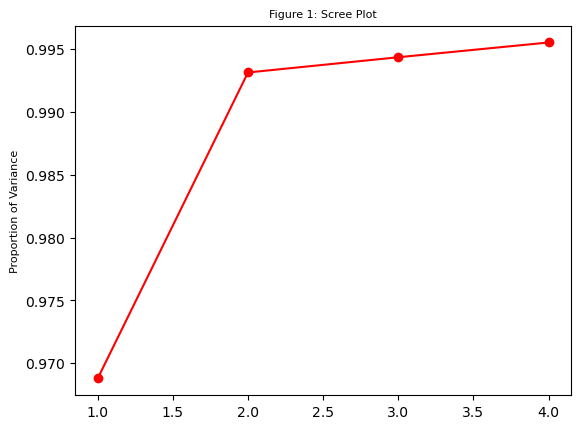

In [23]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(models_output_df[models_output.keys()])

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

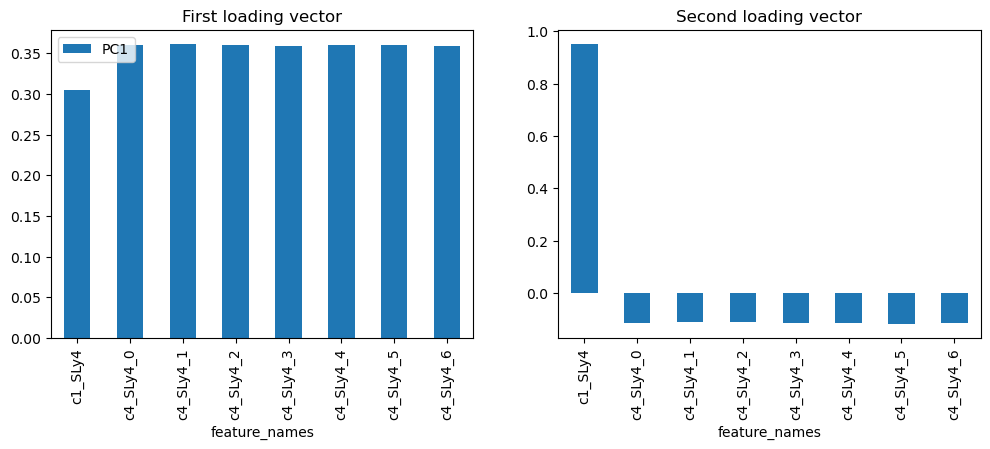

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_SLy4        0.304615  0.952458  0.001646  0.003031
c4_SLy4_0      0.359904 -0.114211 -0.450550 -0.025725
c4_SLy4_1      0.360969 -0.112959 -0.333089 -0.565300
c4_SLy4_2      0.360086 -0.111761  0.387221 -0.280461
c4_SLy4_3      0.359327 -0.115066 -0.374499  0.701553
c4_SLy4_4      0.360033 -0.116166  0.358065  0.019871
c4_SLy4_5      0.360268 -0.118604  0.508130  0.295528
c4_SLy4_6      0.359423 -0.117163 -0.097253 -0.145593


In [24]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

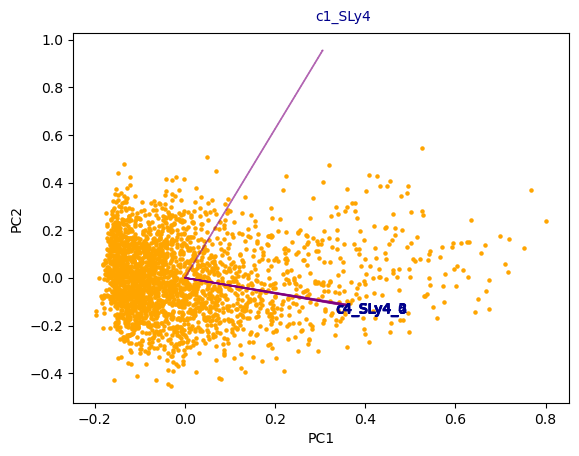

In [25]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))
plt.savefig("Biplot_Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Raw model output -  standardized

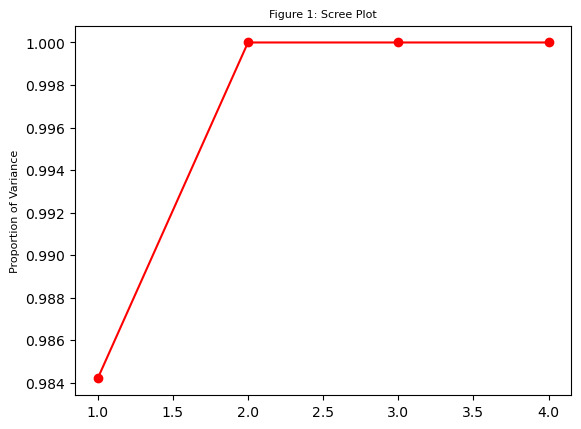

In [14]:
pca = PCA(n_components=4)
X_scaled = StandardScaler().fit_transform(models_output_df[models_output.keys()])
X_pca = pca.fit_transform(X_scaled)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

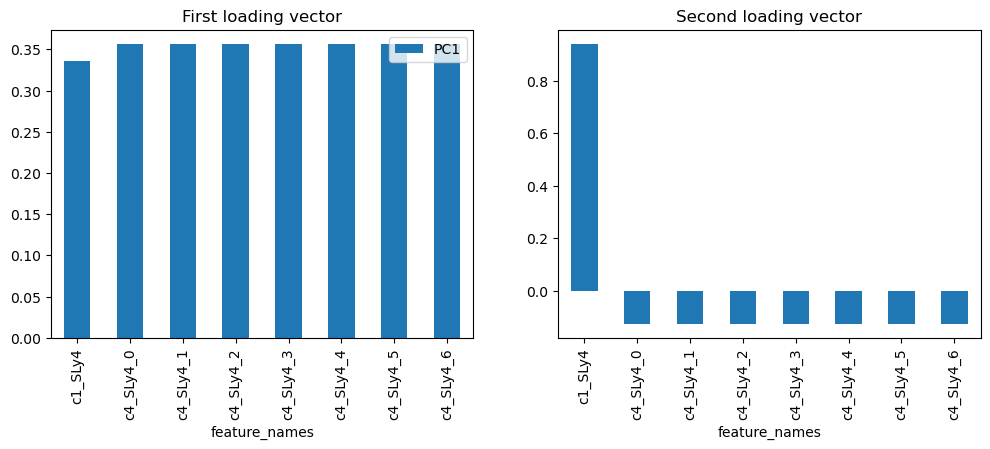

                    PC1       PC2       PC3           PC4
feature_names                                            
c1_SLy4        0.335808  0.941931 -0.000000  0.000000e+00
c4_SLy4_0      0.356016 -0.126923 -0.925820 -1.941078e-16
c4_SLy4_1      0.356016 -0.126923  0.154303  9.128709e-01
c4_SLy4_2      0.356016 -0.126923  0.154303 -1.825742e-01
c4_SLy4_3      0.356016 -0.126923  0.154303 -1.825742e-01
c4_SLy4_4      0.356016 -0.126923  0.154303 -1.825742e-01
c4_SLy4_5      0.356016 -0.126923  0.154303 -1.825742e-01
c4_SLy4_6      0.356016 -0.126923  0.154303 -1.825742e-01


In [15]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

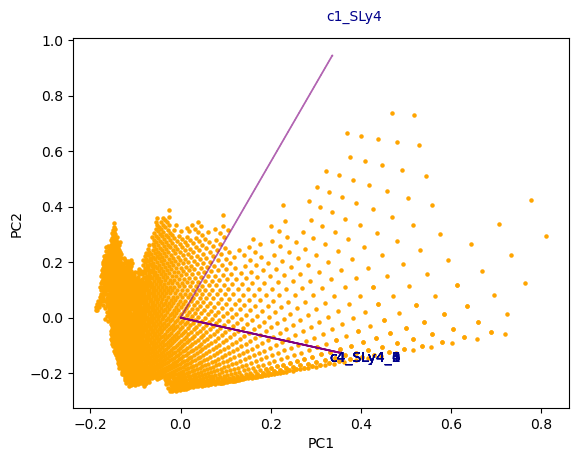

In [16]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Residuals - not standardized

In [159]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 
np.corrcoef(residuals.T)

array([[ 1.00000000e+00, -4.61117583e-02, -9.63616234e-03,
        -7.24455056e-02,  1.59784315e-02,  1.22519949e-02,
        -6.70843810e-02,  2.38534056e-02],
       [-4.61117583e-02,  1.00000000e+00,  3.56001477e-02,
         1.68198707e-02,  2.73766759e-02,  4.55768845e-02,
         6.21881075e-03, -4.37321558e-02],
       [-9.63616234e-03,  3.56001477e-02,  1.00000000e+00,
         2.03178364e-02,  7.61007626e-03, -1.20994459e-02,
         2.90879336e-02, -3.44685324e-02],
       [-7.24455056e-02,  1.68198707e-02,  2.03178364e-02,
         1.00000000e+00,  8.89485207e-04,  2.61783588e-04,
         1.80200649e-02,  1.57998204e-02],
       [ 1.59784315e-02,  2.73766759e-02,  7.61007626e-03,
         8.89485207e-04,  1.00000000e+00,  1.05064717e-01,
        -5.21506245e-03,  3.76508720e-02],
       [ 1.22519949e-02,  4.55768845e-02, -1.20994459e-02,
         2.61783588e-04,  1.05064717e-01,  1.00000000e+00,
         1.58061419e-02,  2.48027104e-02],
       [-6.70843810e-02,  6.218810

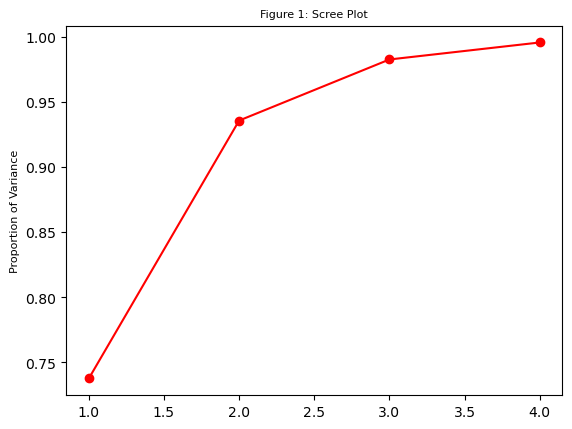

In [160]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(residuals)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_ToyResid_raw_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()

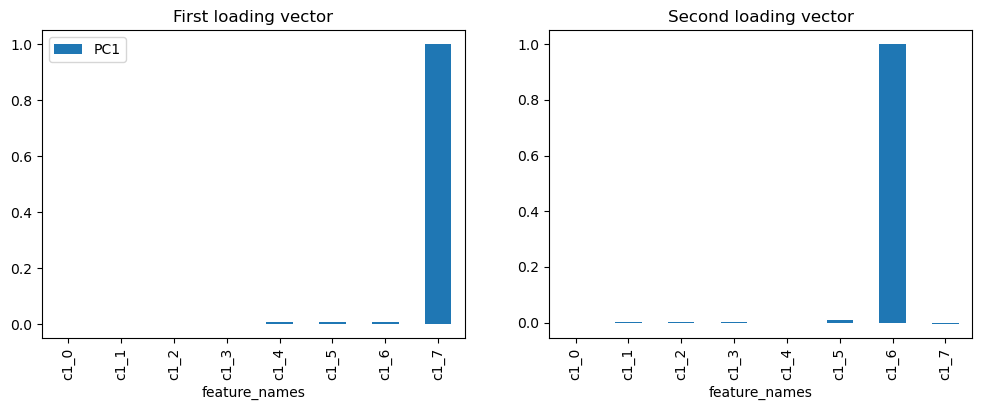

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_0           0.000187 -0.001025 -0.000423 -0.000765
c1_1          -0.000718  0.000221 -0.003118 -0.002826
c1_2          -0.001120  0.001854  0.001488 -0.002826
c1_3           0.001039  0.002282  0.000140 -0.000305
c1_4           0.005166 -0.001430 -0.076897 -0.997016
c1_5           0.006700  0.009839 -0.996961  0.076918
c1_6           0.006047  0.999927  0.009740 -0.002149
c1_7           0.999944 -0.006106  0.007018  0.004644


In [161]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_ToyResid_raw_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

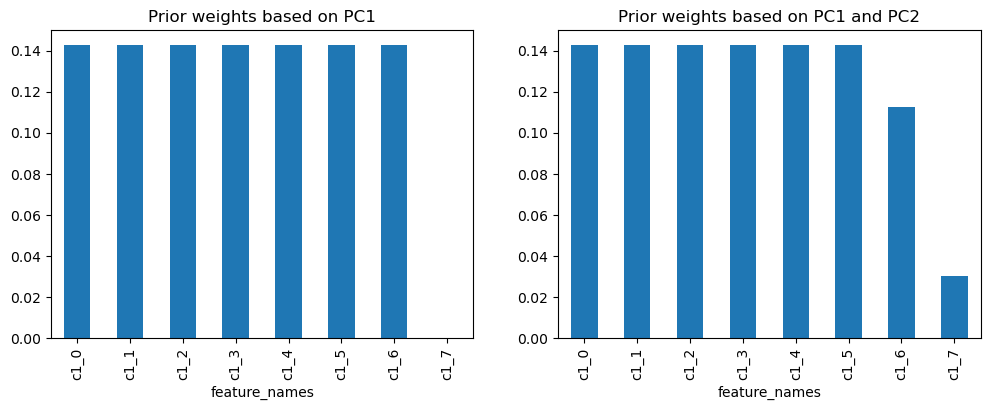

                    PC1       PC2       PC3       PC4       PW1            W2  \
feature_names                                                                   
c1_0           0.000187 -0.001025 -0.000423 -0.000765  0.142857  2.499557e-07   
c1_1          -0.000718  0.000221 -0.003118 -0.002826  0.142857  4.169008e-07   
c1_2          -0.001120  0.001854  0.001488 -0.002826  0.142857  1.716262e-06   
c1_3           0.001039  0.002282  0.000140 -0.000305  0.142857  1.954379e-06   
c1_4           0.005166 -0.001430 -0.076897 -0.997016  0.142853  2.146973e-05   
c1_5           0.006700  0.009839 -0.996961  0.076918  0.142851  5.588693e-05   
c1_6           0.006047  0.999927  0.009740 -0.002149  0.142852  2.117505e-01   
c1_7           0.999944 -0.006106  0.007018  0.004644  0.000016  7.881678e-01   

                    PW2  
feature_names            
c1_0           0.142857  
c1_1           0.142857  
c1_2           0.142857  
c1_3           0.142857  
c1_4           0.142854  
c1_5   

In [162]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

loadings["PW1"] = (1 - loadings["PC1"] ** 2) / np.sum((1 - loadings["PC1"] ** 2))
loadings["W2"] =  (pca.explained_variance_ratio_[0] * loadings["PC1"] ** 2 +  pca.explained_variance_ratio_[1] * loadings["PC2"] ** 2) / np.sum(pca.explained_variance_ratio_[:2])
loadings["PW2"] = (1 - loadings["W2"]) / np.sum((1 - loadings["W2"]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.loc[:, "PW1"].plot(kind = "bar", title = "Prior weights based on PC1", ax = ax1)
loadings.loc[:, "PW2"].plot(kind = "bar", title = "Prior weights based on PC1 and PC2", ax = ax2)
plt.savefig("PC_ToyResid_weightsV1_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

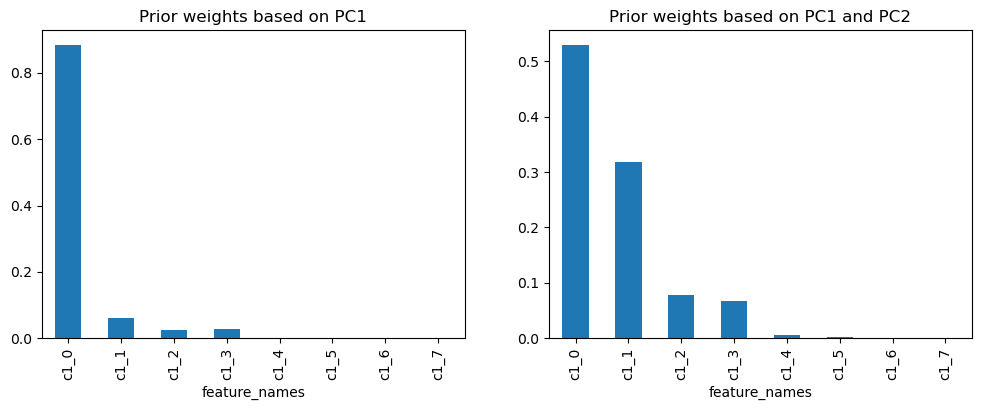

                    PC1       PC2       PC3       PC4           PW1  \
feature_names                                                         
c1_0           0.000187 -0.001025 -0.000423 -0.000765  8.843849e-01   
c1_1          -0.000718  0.000221 -0.003118 -0.002826  5.978108e-02   
c1_2          -0.001120  0.001854  0.001488 -0.002826  2.459893e-02   
c1_3           0.001039  0.002282  0.000140 -0.000305  2.854970e-02   
c1_4           0.005166 -0.001430 -0.076897 -0.997016  1.155350e-03   
c1_5           0.006700  0.009839 -0.996961  0.076918  6.868129e-04   
c1_6           0.006047  0.999927  0.009740 -0.002149  8.431847e-04   
c1_7           0.999944 -0.006106  0.007018  0.004644  3.083700e-08   

                         W2           PW2  
feature_names                              
c1_0           2.499557e-07  5.293224e-01  
c1_1           4.169008e-07  3.173588e-01  
c1_2           1.716262e-06  7.709029e-02  
c1_3           1.954379e-06  6.769780e-02  
c1_4           2.146973e-

In [163]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

loadings["PW1"] = ( 1 / (loadings["PC1"] ** 2)) / np.sum((1/ (loadings["PC1"] ** 2)))
loadings["W2"] =  (pca.explained_variance_ratio_[0] * loadings["PC1"] ** 2 +  pca.explained_variance_ratio_[1] * loadings["PC2"] ** 2) / np.sum(pca.explained_variance_ratio_[:2])
loadings["PW2"] = (1 / loadings["W2"]) / np.sum(( 1/ loadings["W2"]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.loc[:, "PW1"].plot(kind = "bar", title = "Prior weights based on PC1", ax = ax1)
loadings.loc[:, "PW2"].plot(kind = "bar", title = "Prior weights based on PC1 and PC2", ax = ax2)
plt.savefig("PC_ToyResid_weightsV2_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

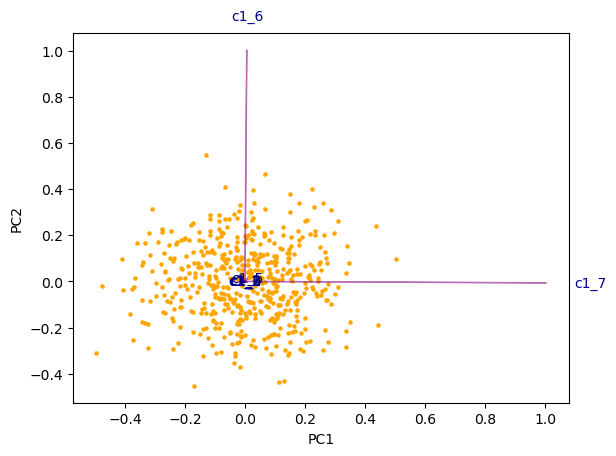

In [164]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_ToyResid_raw_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()

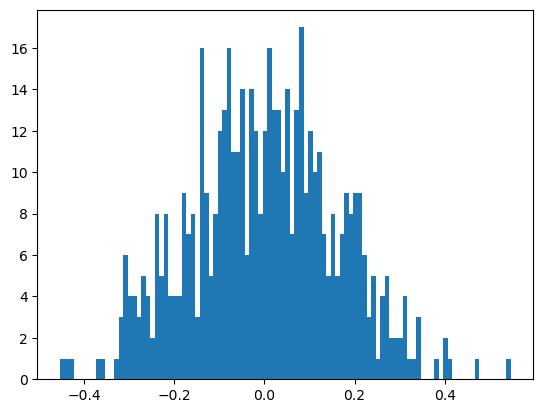

-0.4532031099717104


In [165]:
PCA_2_scaled = X_pca[:,1] / (X_pca[:,1].max() - X_pca[:,1].min())
plt.hist(PCA_2_scaled, bins = 100)
plt.show()
print(PCA_2_scaled.min())

### Residuals - standardized

In [39]:
residuals =masses_truth.values[:,None] - models_output_df[models_output.keys()].values
np.corrcoef(residuals.T)

array([[1.        , 0.62778636, 0.63082676, 0.63039568, 0.63205913,
        0.63182642, 0.63350399, 0.63375794],
       [0.62778636, 1.        , 0.96333256, 0.96362353, 0.96340014,
        0.96324756, 0.96378094, 0.96404966],
       [0.63082676, 0.96333256, 1.        , 0.96364325, 0.96414591,
        0.96413814, 0.96317014, 0.96321517],
       [0.63039568, 0.96362353, 0.96364325, 1.        , 0.96364073,
        0.96325216, 0.96356181, 0.96301385],
       [0.63205913, 0.96340014, 0.96414591, 0.96364073, 1.        ,
        0.96270806, 0.96503558, 0.96480633],
       [0.63182642, 0.96324756, 0.96413814, 0.96325216, 0.96270806,
        1.        , 0.96391925, 0.96364462],
       [0.63350399, 0.96378094, 0.96317014, 0.96356181, 0.96503558,
        0.96391925, 1.        , 0.96464574],
       [0.63375794, 0.96404966, 0.96321517, 0.96301385, 0.96480633,
        0.96364462, 0.96464574, 1.        ]])

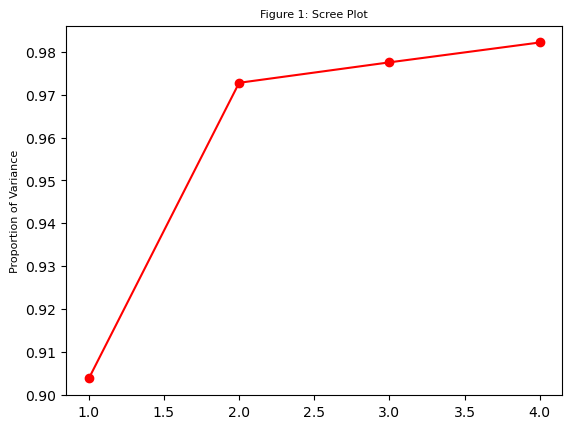

In [40]:
pca = PCA(n_components=4)
X_scaled = StandardScaler().fit_transform(residuals)
X_pca = pca.fit_transform(X_scaled)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

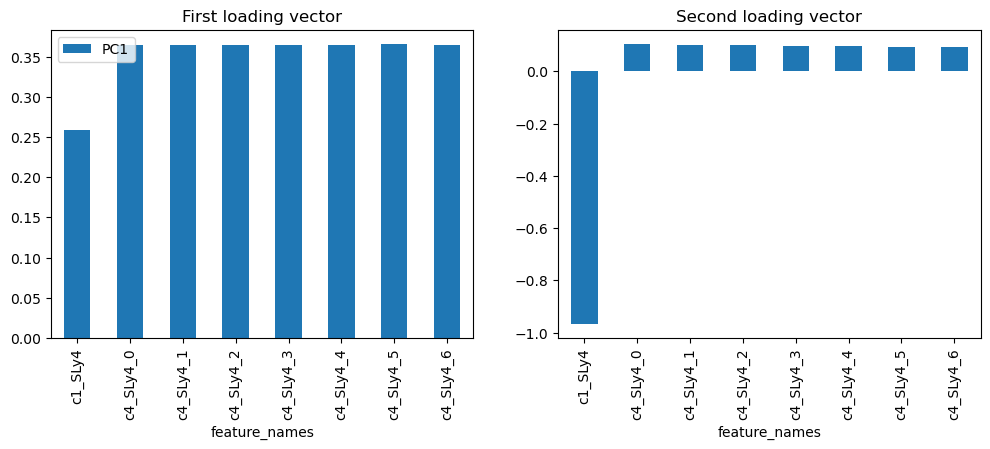

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_SLy4        0.259002 -0.965837  0.003822  0.004547
c4_SLy4_0      0.364892  0.104596 -0.010321  0.235335
c4_SLy4_1      0.365012  0.098946  0.449792 -0.047038
c4_SLy4_2      0.364951  0.099586  0.308161  0.676521
c4_SLy4_3      0.365163  0.097015 -0.416206  0.143766
c4_SLy4_4      0.365011  0.096927  0.460540 -0.617799
c4_SLy4_5      0.365234  0.094389 -0.364954 -0.147464
c4_SLy4_6      0.365206  0.093777 -0.429053 -0.246197


In [41]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

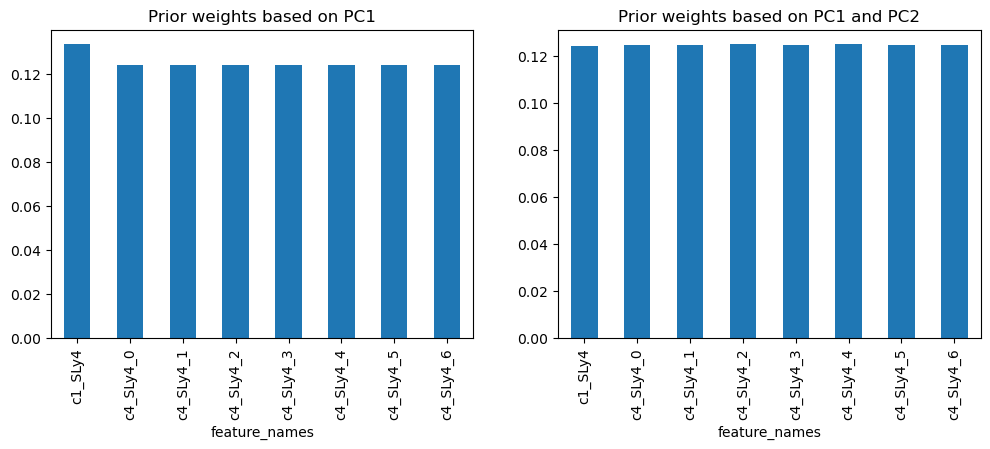

                    PC1       PC2       PC3       PC4       PW1        W2  \
feature_names                                                               
c1_SLy4        0.259002 -0.965837  0.003822  0.004547  0.133274  0.128496   
c4_SLy4_0      0.364892  0.104596 -0.010321  0.235335  0.123836  0.124478   
c4_SLy4_1      0.365012  0.098946  0.449792 -0.047038  0.123824  0.124477   
c4_SLy4_2      0.364951  0.099586  0.308161  0.676521  0.123830  0.124445   
c4_SLy4_3      0.365163  0.097015 -0.416206  0.143766  0.123808  0.124553   
c4_SLy4_4      0.365011  0.096927  0.460540 -0.617799  0.123824  0.124448   
c4_SLy4_5      0.365234  0.094389 -0.364954 -0.147464  0.123801  0.124565   
c4_SLy4_6      0.365206  0.093777 -0.429053 -0.246197  0.123804  0.124538   

                    PW2  
feature_names            
c1_SLy4        0.124501  
c4_SLy4_0      0.125075  
c4_SLy4_1      0.125075  
c4_SLy4_2      0.125079  
c4_SLy4_3      0.125064  
c4_SLy4_4      0.125079  
c4_SLy4_5      0.1250

In [42]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

loadings["PW1"] = (1 - loadings["PC1"] ** 2) / np.sum((1 - loadings["PC1"] ** 2))
loadings["W2"] =  (pca.explained_variance_ratio_[0] * loadings["PC1"] ** 2 +  pca.explained_variance_ratio_[1] * loadings["PC2"] ** 2) / np.sum(pca.explained_variance_ratio_[:2])
loadings["PW2"] = (1 - loadings["W2"]) / np.sum((1 - loadings["W2"]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.loc[:, "PW1"].plot(kind = "bar", title = "Prior weights based on PC1", ax = ax1)
loadings.loc[:, "PW2"].plot(kind = "bar", title = "Prior weights based on PC1 and PC2", ax = ax2)
#plt.savefig("PC_ToyResid_weightsV1.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

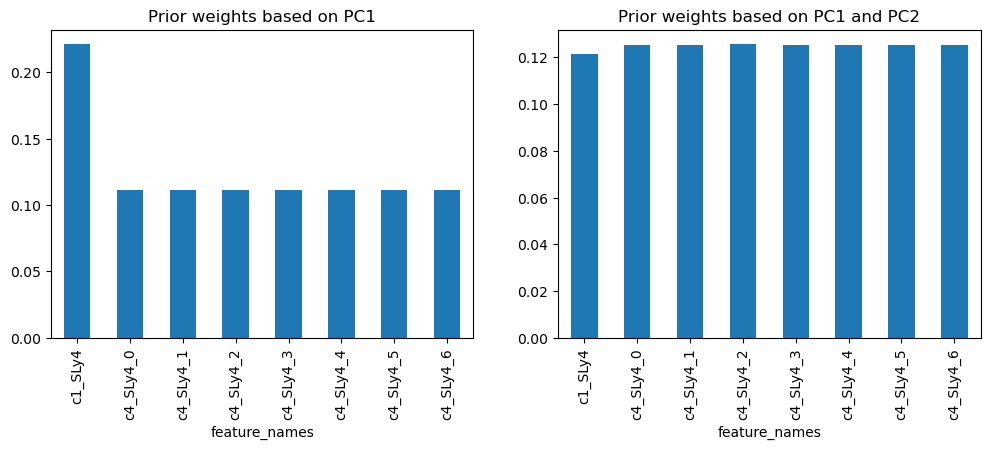

                    PC1       PC2       PC3       PC4       PW1        W2  \
feature_names                                                               
c1_SLy4        0.259002 -0.965837  0.003822  0.004547  0.221073  0.128496   
c4_SLy4_0      0.364892  0.104596 -0.010321  0.235335  0.111382  0.124478   
c4_SLy4_1      0.365012  0.098946  0.449792 -0.047038  0.111309  0.124477   
c4_SLy4_2      0.364951  0.099586  0.308161  0.676521  0.111346  0.124445   
c4_SLy4_3      0.365163  0.097015 -0.416206  0.143766  0.111217  0.124553   
c4_SLy4_4      0.365011  0.096927  0.460540 -0.617799  0.111309  0.124448   
c4_SLy4_5      0.365234  0.094389 -0.364954 -0.147464  0.111173  0.124565   
c4_SLy4_6      0.365206  0.093777 -0.429053 -0.246197  0.111191  0.124538   

                    PW2  
feature_names            
c1_SLy4        0.121586  
c4_SLy4_0      0.125511  
c4_SLy4_1      0.125511  
c4_SLy4_2      0.125544  
c4_SLy4_3      0.125435  
c4_SLy4_4      0.125540  
c4_SLy4_5      0.1254

In [43]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

loadings["PW1"] = ( 1 / (loadings["PC1"] ** 2)) / np.sum((1/ (loadings["PC1"] ** 2)))
loadings["W2"] =  (pca.explained_variance_ratio_[0] * loadings["PC1"] ** 2 +  pca.explained_variance_ratio_[1] * loadings["PC2"] ** 2) / np.sum(pca.explained_variance_ratio_[:2])
loadings["PW2"] = (1 / loadings["W2"]) / np.sum(( 1/ loadings["W2"]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.loc[:, "PW1"].plot(kind = "bar", title = "Prior weights based on PC1", ax = ax1)
loadings.loc[:, "PW2"].plot(kind = "bar", title = "Prior weights based on PC1 and PC2", ax = ax2)
#plt.savefig("PC_ToyResid_weightsV2.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

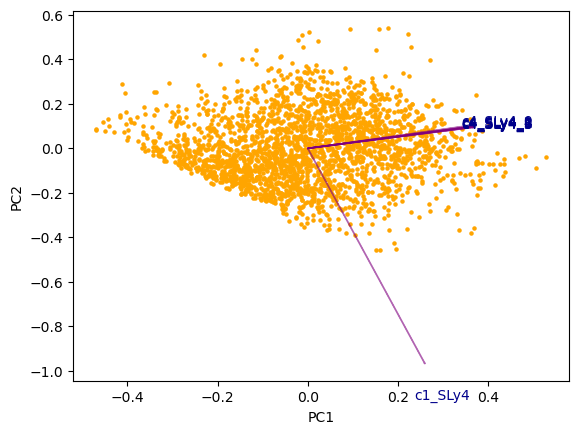

In [44]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()